In [2]:
import sys
import logging
import time
import numpy as np
import pandas as pd

from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l1_l2

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


### 5-fold cross validation

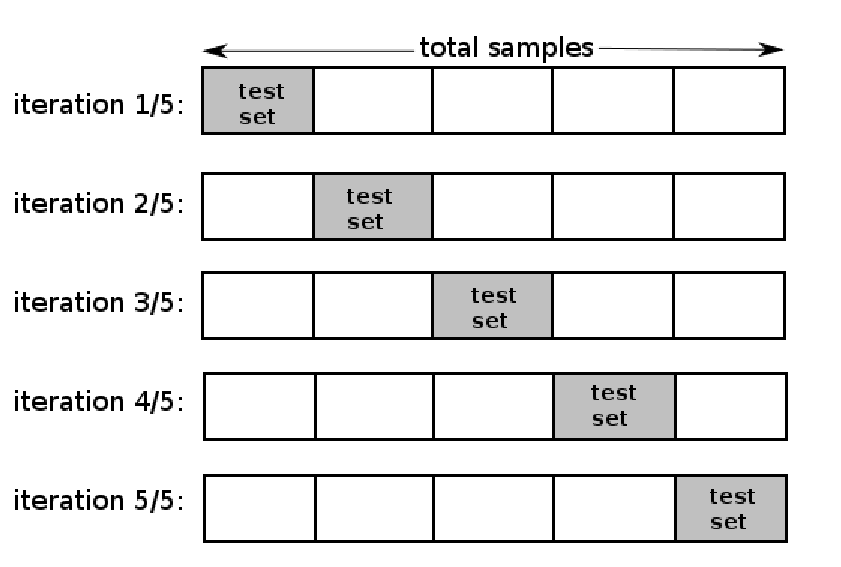

In [3]:
Image(filename="./addition/cross_validation.png", width=700, height=700)

### Average predictions

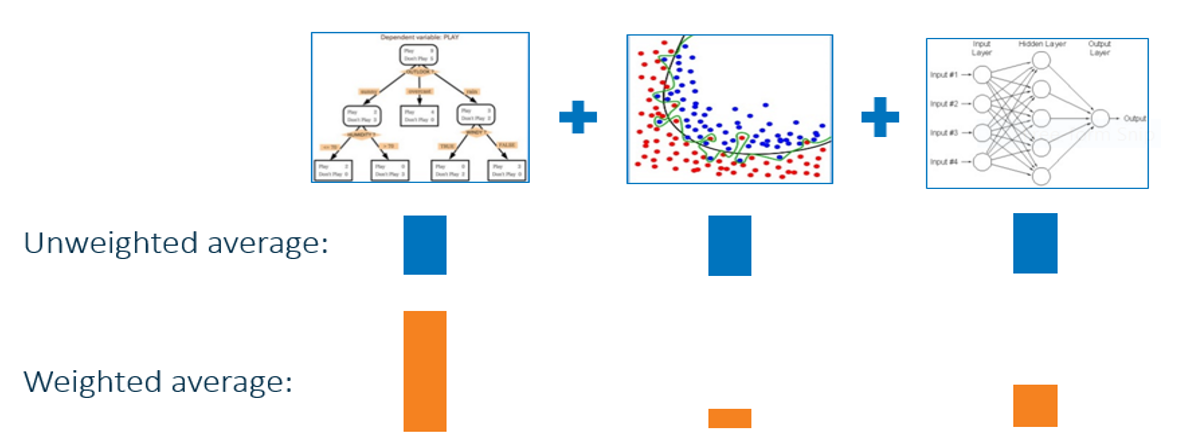

In [14]:
Image(filename="./addition/average_predictions.png", width=700, height=700)

### Stacking

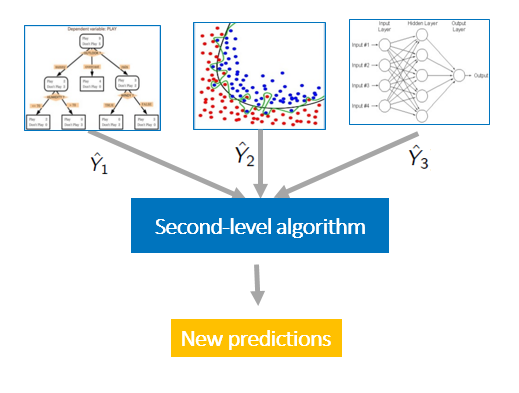

In [11]:
Image(filename="./addition/stacking.png", width=700, height=700)

### Solution architecture

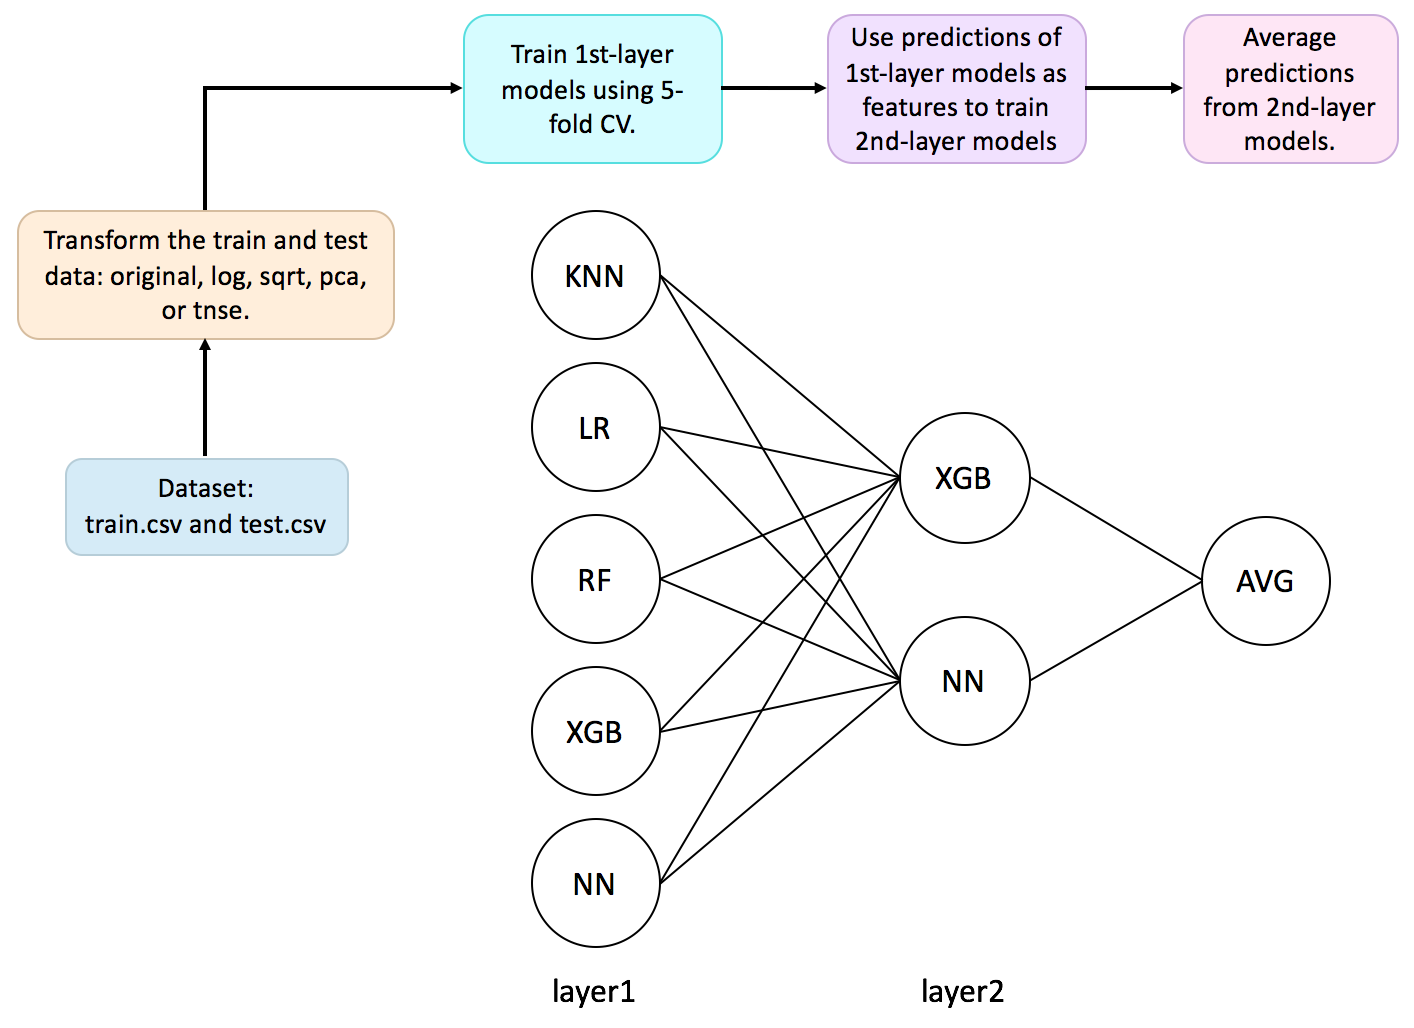

In [12]:
Image(filename="./addition/solution_diagram.png", width=700, height=700)

### Auxiliary functions for data preprocessing

In [3]:
def standarize_feature(train_df, test_df, cols):
    scaler = StandardScaler()
    for col in cols:
        train_df[col] = scaler.fit_transform(train_df[col].reshape(-1,1).astype(np.float32))
        test_df[col] = scaler.transform(test_df[col].reshape(-1,1).astype(np.float32))
    return None

def load_data(train_data_path='./train.csv', test_data_path = './test.csv'):
    train_df = pd.read_csv(train_data_path, sep=',', index_col=0, header=0)
    test_df = pd.read_csv(test_data_path, sep=',', index_col=0, header=0)
    
    train_df['target'] = LabelEncoder().fit_transform(train_df['target'])
        
    return train_df, test_df


def process_data(train_df, test_df, ylabel='target', standarization=False, transform=None):
    numerical_features = train_df.columns

    if standarization:
        standarized_features = numerical_features
        standarize_feature(train_df, test_df, standarized_features)
    
    X = train_df.drop(ylabel, axis=1).as_matrix()
    y = train_df[ylabel].as_matrix()
    X_submission = test_df.as_matrix()
    
    if transform == 'log':
        X = np.log1p(X)
        X_submission = np.log1p(X_submission)
    elif transform == 'sqrt':
        X = np.sqrt(X + 3.0 / 8)
        X_submission = np.sqrt(X_submission + 3.0 / 8)
    elif transform == 'pca':
        pca = PCA(n_components=3).fit(X)
        X = pca.transform(X)
        X_submission = pca.transform(X_submission)
    elif transform == 'tsne':
        tsne = TSNE(n_components=3).fit(X)
        X = tsne.transform(X)
        X_submission = tsne.transform(X_submission)
    elif transform == 'pca+':
        pca = PCA(n_components=0.95).fit(X)
        X = np.hstack((X, pca.transform(X)))
        X_submission = np.hstack((X, pca.transform(X)))
    elif transform == 'tsne+':
        tsne = TSNE(n_components=3).fit(X)
        X = np.hstack((X, tsne.transform(X)))
        X_submission = np.hstack((X_submission, tsne.transform(X_submission)))        
    return X, y, X_submission

### Auxiliary functions for training models

In [5]:
def evaluate(y, y_pred):
    logloss = log_loss(y, y_pred)
    return logloss

def models_CV_train(models, X, y, X_submission, n_classes, n_folds=5):
    summary = {}

    skf = list(StratifiedKFold(n_folds, random_state=0).split(X, y))
    
    stack_train = np.zeros((X.shape[0], n_classes, len(models)))
    stack_test = np.zeros((X_submission.shape[0], n_classes, len(models)))
    
    for i, model in enumerate(models):
        print("Model {0}, {1}".format(i, model))
        
        avg_logloss = 0
        
        stack_test_model_i = np.zeros((X_submission.shape[0], n_classes, len(skf)))
        for j, (train_idx, test_idx) in enumerate(skf):
            print("  Fold {0}".format(j))
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]

            model.fit(X_train, y_train)
            
            y_test_pred = model.predict_proba(X_test)          
            stack_train[test_idx, :, i] = y_test_pred
            
            logloss = evaluate(y_test, y_test_pred)
            avg_logloss += logloss
            print("  logloss: {0}".format(logloss))
            
            y_submission_pred = model.predict_proba(X_submission)           
            stack_test_model_i[:, :, j] = y_submission_pred
        
        avg_logloss = avg_logloss / n_folds
        print("model average logloss: {0}".format(avg_logloss))
        summary[i] = avg_logloss
        
        stack_test[:, :, i] = stack_test_model_i.mean(axis=2)

    return np.swapaxes(stack_train, 1, 2).reshape((X.shape[0], -1)),
           np.swapaxes(stack_test, 1, 2).reshape((X_submission.shape[0], -1)), 
           summary


def stacking_models_CV_train(models, X, y, X_submission, n_classes, n_folds=5):
    skf = list(StratifiedKFold(n_folds, random_state=42).split(X, y))
    
    y_submission_pred = np.zeros((X_submission.shape[0], n_classes, len(models)))
        
    for i, model in enumerate(models):
        print("Stacking Model {0}, {1}".format(i, model))
        avg_logloss = 0
        y_submission_pred_model_i = np.zeros((X_submission.shape[0], n_classes, len(skf)))
        for j, (train_idx, test_idx) in enumerate(skf):
            print("  Fold {0}".format(j))
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]

            model.fit(X_train, y_train)

            y_test_pred = model.predict_proba(X_test)          

            logloss = evaluate(y_test, y_test_pred)
            avg_logloss += logloss
            print("  logloss: {0}".format(logloss))

            y_submission_pred_model_i[:, :, j] = model.predict_proba(X_submission)

        avg_logloss = avg_logloss / n_folds
        print("model average logloss: {0}".format(avg_logloss))

        y_submission_pred[:, :, i] = y_submission_pred_model_i.mean(axis=2)

    return y_submission_pred  

### Neural network architectures

In [6]:
def create_2_layer_keras_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dropout(0.05, input_shape=(input_dim,)))
    model.add(Dense(512, init='glorot_normal', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5)))
    model.add(Dropout(0.5))
    model.add(Dense(256, init='glorot_normal', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5)))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, init='glorot_normal', activation='softmax', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5)))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'categorical_crossentropy'])
    return model

def create_3_layer_keras_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dropout(0.05, input_shape=(input_dim,)))
    model.add(Dense(1024, init='glorot_normal', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5)))
    model.add(Dropout(0.5))    
    model.add(Dense(512, init='glorot_normal', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5)))
    model.add(Dropout(0.5))
    model.add(Dense(256, init='glorot_normal', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5)))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, init='glorot_normal', activation='softmax', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-5)))
    
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 'categorical_crossentropy'])
    return model

### Load and preprocess the data

In [ ]:
train_df, test_df = load_data(train_data_path='./train.csv', test_data_path='./test.csv')
X, y, X_submission = process_data(train_df, test_df, transform='sqrt')

### Training phase 1

In [ ]:
models = []

# KNN
models += [KNeighborsClassifier(n_neighbors=2, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=4, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=8, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=16, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=32, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=64, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=128, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=256, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=512, n_jobs=-1),
           KNeighborsClassifier(n_neighbors=1024, n_jobs=-1)]

# Logistic Regression
models += [LogisticRegression(penalty='l1', solver='liblinear', n_jobs=-1, C=0.43, class_weight=None),
           LogisticRegression(penalty='l2', solver='lbfgs', n_jobs=-1, C=0.01, 
                              class_weight=None, multi_class='multinomial')]

# Random Forest
models += [RandomForestClassifier(criterion='gini', n_jobs=-1, n_estimators=250, 
                                  max_features=18, min_samples_split=5, max_depth=46, class_weight=None)]

# sklearn extra-trees classifier
models += [ExtraTreesClassifier(criterion='gini', n_estimators=500, n_jobs=-1)]

# xgboost
models += [XGBClassifier(base_score=0.5, colsample_bylevel=1,
                         colsample_bytree=0.6, gamma=0,
                         learning_rate=0.03, max_delta_step=0, max_depth=28,
                         min_child_weight=6, n_estimators=2, nthread=-1,
                         objective='multi:softprob', reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=1, seed=0, silent=True, subsample=0.8)]

# NN
models += [KerasClassifier(build_fn=create_2_layer_keras_model, input_dim=93, 
                           output_dim=9, nb_epoch=100, batch_size=256, verbose=0),
           KerasClassifier(build_fn=create_3_layer_keras_model, input_dim=93, 
                           output_dim=9, nb_epoch=100, batch_size=256, verbose=0)]

In [ ]:
print('List of models to train and ensemble:')
for model in models:
    print(model)
num_models = len(models)    

train_models_pred, test_models_pred, summary = models_CV_train(models, X, y, X_submission, n_classes=9, n_folds=5)

# save phase 1 intermediate prediction results
np.savetxt('./train_models_pred.csv', train_models_pred)
np.savetxt('./test_models_pred.csv', test_models_pred)

print('Summary for phase 1 model performance:')
for i in sorted(summary.keys()):
    print ('Model {0}: {1}'.format(i, summary[i]))

#### Training phase 2: stacking model predictions from phase 1

In [ ]:
stacking_models = []
# stacking models' predictions using xgboost
stacking_models +=[XGBClassifier(base_score=0.5, colsample_bylevel=1,
                                 colsample_bytree=0.6, gamma=0,
                                 learning_rate=0.03, max_delta_step=0, max_depth=90,
                                 min_child_weight=6, n_estimators=500, nthread=-1,
                                 objective='multi:softprob', reg_alpha=0, reg_lambda=1,
                                 scale_pos_weight=1, seed=0, silent=True, subsample=0.8)]

# stacking models' predictions using NN
stacking_models += [KerasClassifier(build_fn=create_2_layer_keras_model, input_dim=num_models*9, 
                                    output_dim=9, nb_epoch=2, batch_size=256, verbose=0)]

y_submission_pred = stacking_models_CV_train(stacking_models, train_models_pred, y, test_models_pred, 
                                             n_classes=9, n_folds=5)
y_submission_pred = y_submission_pred.mean(axis=2)

#### Write submission: averaging stacking models' predictions

In [ ]:
timestamp = time.strftime("%Y-%m-%d_%H:%M:%S")
columns = ['Class_' + str(i + 1) for i in range(9)]
submission_df = pd.DataFrame(y_submission_pred, columns=columns)
submission_df.index = submission_df.index + 1
submission_df.to_csv('./submission_{0}.csv'.format(timestamp), sep=',', index_label='id')

end_time = time.time()